# k-mean clustering 

In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# Reading the data on which analysis needs to be done

retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
# shape of df

retail.shape

(541909, 8)

In [4]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# df description

retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# data cleaning

In [6]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [7]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 8)

In [8]:
# Changing the datatype of Customer Id as per Business understanding

retail['CustomerID'] = retail['CustomerID'].astype(str)

# Data Preparation

In [9]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [10]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [11]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [12]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [13]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [14]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [15]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [16]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [17]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

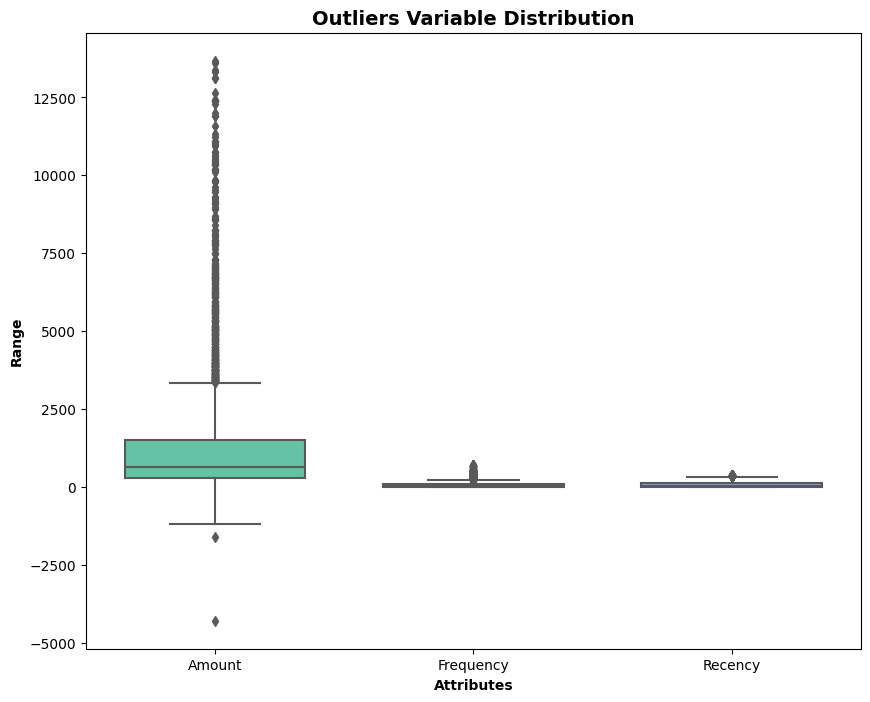

In [20]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [21]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [22]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4271, 3)

In [23]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.759639,-0.771795,2.295613
1,1.916220,1.117217,-0.910045
2,0.356175,-0.467454,-0.187782
3,0.331534,-0.026685,-0.741847
4,-0.552027,-0.614377,2.137309


# Building the Model
K-Means Clustering

In [24]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [25]:
kmeans.labels_

array([0, 3, 1, ..., 0, 1, 1])

# Finding the Optimal Number of Clusters
Elbow Curve to get the right number of Clusters

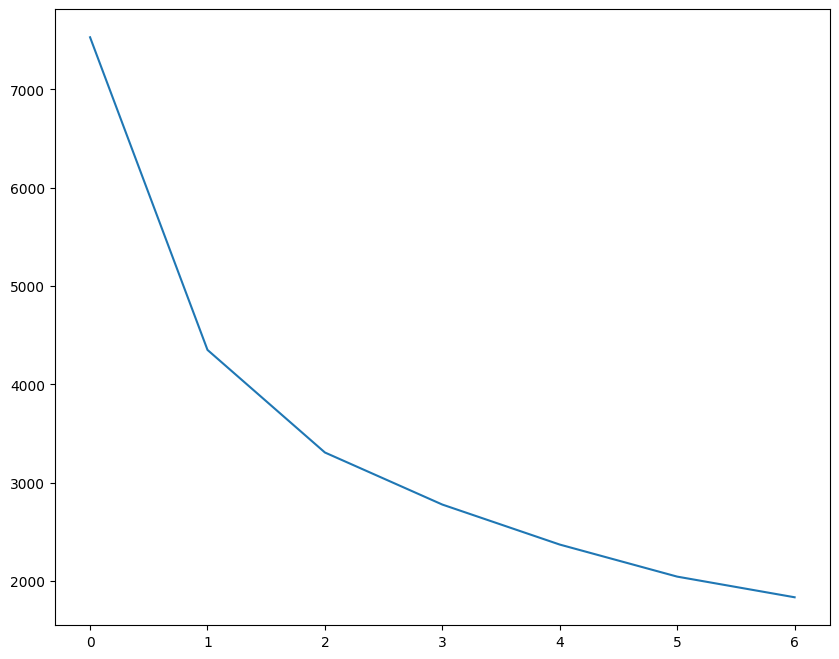

In [26]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

Silhouette Analysis

In [27]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
 

For n_clusters=2, the silhouette score is 0.5267442774056142
For n_clusters=3, the silhouette score is 0.5022535831650203
For n_clusters=4, the silhouette score is 0.4781646507106878
For n_clusters=5, the silhouette score is 0.4602914241053448
For n_clusters=6, the silhouette score is 0.4138624144221166
For n_clusters=7, the silhouette score is 0.4061028867167543
For n_clusters=8, the silhouette score is 0.40156343160237085


In [28]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [29]:
 kmeans.labels_

array([0, 2, 1, ..., 0, 1, 1])

In [30]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0


<Axes: xlabel='Cluster_Id', ylabel='Amount'>

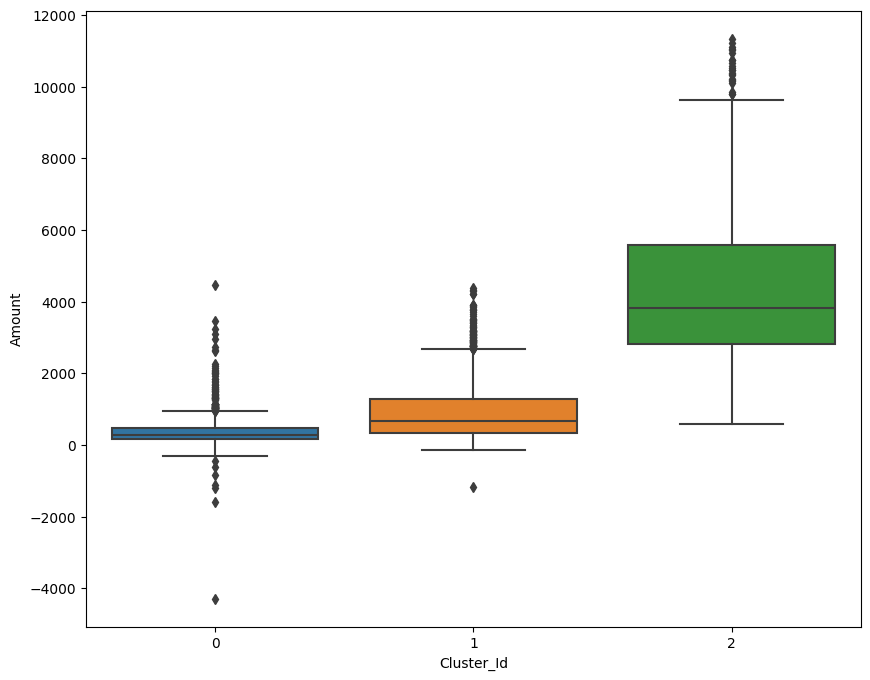

In [31]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

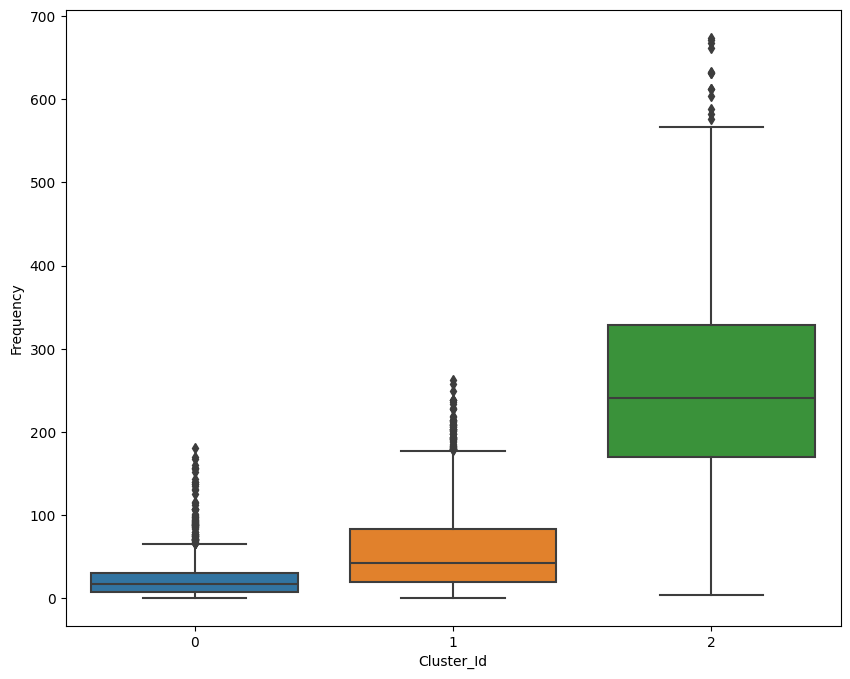

In [32]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

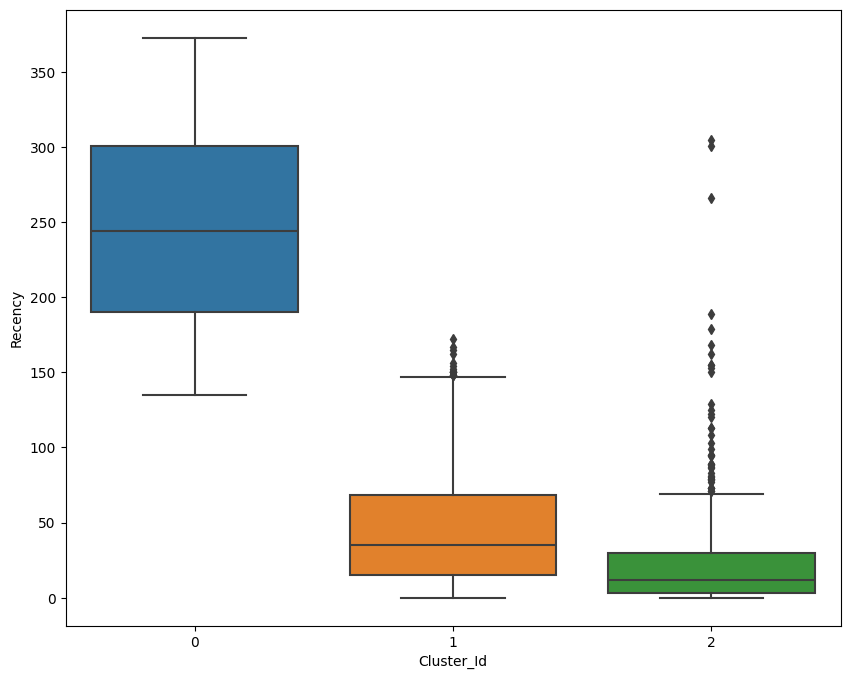

In [33]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)